# Sistemas Dinâmicos e Controlo - Projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import StateSpace, lsim, step, lti
from pprint import pprint
import scipy.integrate as integrate

In [2]:
m = 1.5 * 10 ** -1 # motorcycle mass
g = 9.81 # gravity
h = 8.0 * 10 ** -1 # height of center of mass
I = 1.5 * 10 ** -2 # moment of inertia

## Ex. 1

$$ I \ddot{\theta} = mgh \cdot sin(\theta) + \tau $$

At small angles $ sin(\theta) \approx \theta $.

$$ I \ddot{\theta} = mgh \cdot \theta + \tau $$

$$ \ddot{\theta} = \frac{mgh \cdot \theta}{I} + \frac{\tau}{I} $$

$$ x = \begin{bmatrix} 
 \theta \\
 \dot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \ddot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta + \frac{\tau}{I} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  \Leftrightarrow \dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  $$

Since $ u = \tau $:

$$
\dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{1}{I}
\end{bmatrix} u $$

Since $\theta$ and $\dot{\theta}$ are also the output, $y$:

$$ y = C \cdot x \Leftrightarrow y = C \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow y = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow C = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} $$
 


In [3]:
A = np.array([[0, 1],[m * g * h / I, 0]])
B = np.array([[0],[1 / I]])
C = np.array([[1, 0],[0, 1]])
D = np.array([[0],[0]])

print("Matriz A: ")
pprint(A)
print("Matrix B: ")
pprint(B)
print("Matrix C: ")
pprint(C)

Matriz A: 
array([[ 0.  ,  1.  ],
       [78.48,  0.  ]])
Matrix B: 
array([[ 0.        ],
       [66.66666667]])
Matrix C: 
array([[1, 0],
       [0, 1]])


## Ex.2

Controlability Matrix:

$$ Q = \begin{bmatrix} B & AB & A^{2}B & ... & A^{n-1}B \end{bmatrix} $$

Since $n=2$ and the controlability matrix is squared, if $ |Q| \neq 0 $, the system is controllable, if $ |Q| = 0 $, the system is not controllable.

$$ Q = \begin{bmatrix} B & AB  \end{bmatrix} $$

Other way to check, is to see if $rank(Q)=n$, then it's controllable.

In [4]:
Q = np.hstack([B, A @ B])
n=2

In [5]:
print("Controlability Matrix: ")
pprint(Q)
print("Determinant: ", np.linalg.det(Q))
print("Rank: ", np.linalg.matrix_rank(Q))

if np.linalg.det(Q) != 0:
    print("According to the determinant, the system is controllable")
else:
    print("According to the determinant, the system is not controllable")

if np.linalg.matrix_rank(Q) == n:
    print("According to the rank, the system is controllable.")
else:
    print("According to the rank, the system is not controllable.")

Controlability Matrix: 
array([[ 0.        , 66.66666667],
       [66.66666667,  0.        ]])
Determinant:  -4444.444444444446
Rank:  2
According to the determinant, the system is controllable
According to the rank, the system is controllable.


Observability Matrix:


$$ O = \begin{bmatrix} C \\ CA \\ CA^{2} \\ ... \\ CA^{n-1} \end{bmatrix} $$

If $rank(O)=n$, it's observable.

In [6]:
O = np.vstack([C, C @ A])  # Stack rows for observability

print("Observability Matrix:")
pprint(O)
print("Rank: ", np.linalg.matrix_rank(O))

if np.linalg.matrix_rank(O) == n: #n continua a ser 2 porque é o número de estados
    print("According to the rank, the system is observable.")
else:
    print("According to the rank, the system is not observable.")

Observability Matrix:
array([[ 1.  ,  0.  ],
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ],
       [78.48,  0.  ]])
Rank:  2
According to the rank, the system is observable.


Stability:

A system is stable if the real part of the eigenvalues is negative.

In [7]:
eigval, eigvect = np.linalg.eig(A)

print("Eigenvalues: ",eigval)

if eigval.real.any()<0: 
    print("The system is stable.")
else:
    print("The system is not stable.")

Eigenvalues:  [ 8.85889384 -8.85889384]
The system is not stable.


To stabilize this system, we can introduce a controller $K=[k_1 k_2]$ such that it stabilizes with poles at the system eigenvalues:

$$ det(sI-A+BK) = (s-\lambda_1)(s-\lambda_2) = (s - \lambda)^2 = s^2 - 2\lambda s + \lambda^2$$

where $\lambda$ is a negative eigenvalue that we choose to place.

Where: 

$$ det(sI-A+BK) =  
det \begin{bmatrix} 
 s & -1 \\
 -\frac{mgh}{I}+\frac{k_1}{I}  & s+\frac{k_2}{I}\\
\end{bmatrix}  = s^2 + \frac{k_2}{I}s +1(\frac{k_1}{I}-\frac{mgh}{I})
$$

So:

$$ k_2=-2\lambda I $$ 
and 
$$ k_1=I\lambda^2 + mgh $$

This way, the system can be stabilized.

Controller:  [[1.2372 0.06  ]]


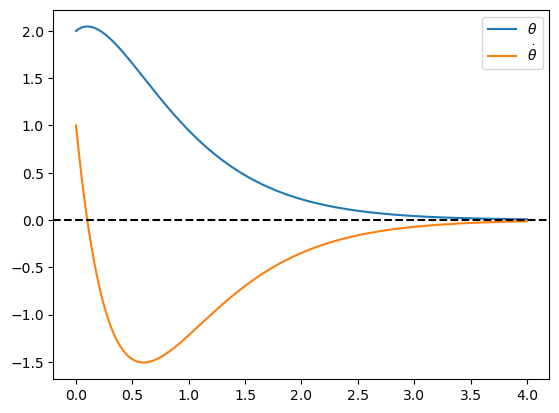

In [8]:
K = np.hstack([I*(-2)**2+m*g*h,-2*(-2)*I]).reshape((1,2))

print("Controller: ",K)

x0 = np.array([2,1])
times = np.linspace(0, 4, 10000, endpoint=True)
dt = abs(times[1]-times[0])
xt = np.zeros((len(times), 2))
xt[0] = x0
for i in range(len(times)-1):
    xt[i+1] = xt[i] + dt*(A - B @ K) @ xt[i]

plt.plot(times, xt[:,0], label=r"$\theta$")
plt.plot(times, xt[:,1], label=r"$\dot{\theta}$")
plt.axhline(0, color='k', linestyle='--')
plt.legend()
plt.show()

Verificamos que desde que os valores próprios tenham parte real negativa, o sistema é estável.

## Ex.3

In [9]:
# Sistema no formato lti (linear time-invariant)
sys = lti(A, B, C, D)

time = np.linspace(0, 5, 50)  # tempo de simulação

#### a) Step input, u = 10**-2, and null initial conditions, x0 = [0, 0]

In [10]:
# Resposta temporal - Condição inicial nula e entrada tipo degrau
u_step = np.ones_like(time) * 1e-2  # degrau de magnitude 10^-2 (eu não sei se aqui ele quer só a constante ou vários degraus)
x0_zero = [0, 0]  # condição inicial nula

# Simulação para entrada tipo degrau
_, y_step, _ = lsim(sys, U=u_step, T=time, X0=x0_zero)

#### b) Null input, u = 0, and non-null initial conditions, x0 = [x01, x02]

In [11]:
# Resposta temporal - Condição inicial não nula e entrada nula
x0_nonzero = [100,100]  # condição inicial não nula
u_zero = np.zeros_like(time)  # entrada nula

# Simulação para condição inicial não nula
_, y_initial, _ = lsim(sys, U=u_zero, T=time, X0=x0_nonzero)

Gráficos

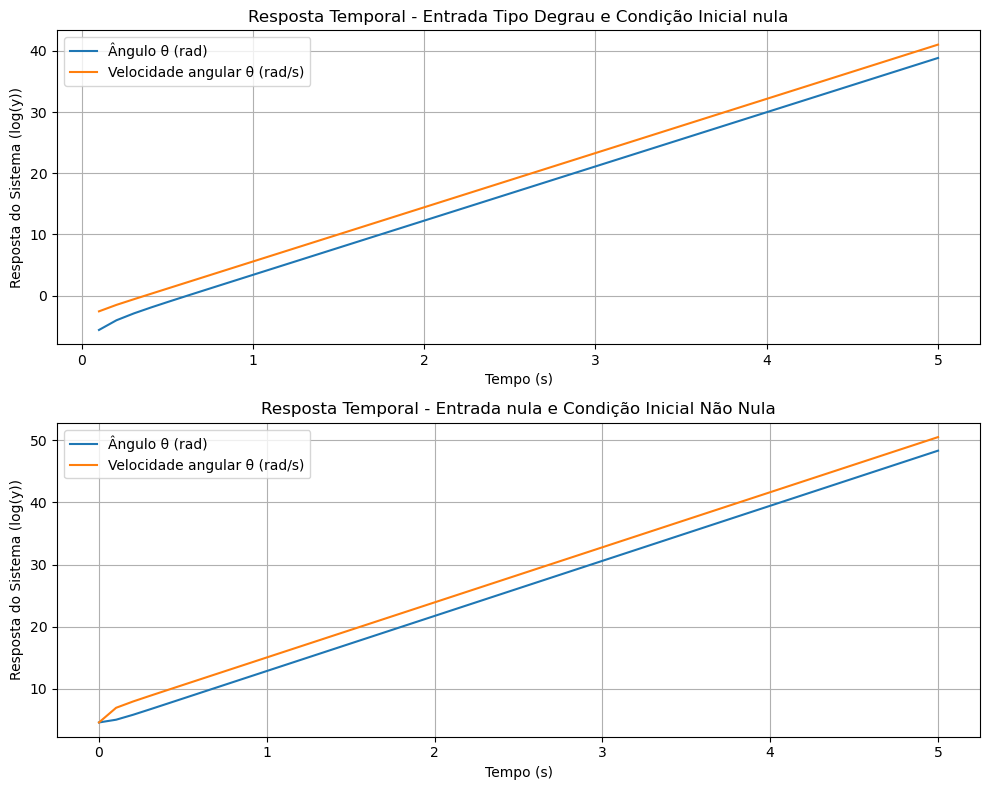

In [12]:
# Gráficos para análise
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico para entrada degrau (aqui tirei o primeiro ponto do gráfico porque dá erro pôr 0 no log)
axs[0].plot(time[1:], np.log(y_step[1:, 0]), label="Ângulo θ (rad)")
axs[0].plot(time[1:], np.log(y_step[1:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[0].set_title("Resposta Temporal - Entrada Tipo Degrau e Condição Inicial nula")
axs[0].set_xlabel("Tempo (s)")
axs[0].set_ylabel("Resposta do Sistema (log(y))")
axs[0].legend()
axs[0].grid()

# Gráfico para condição inicial não nula
axs[1].plot(time, np.log(y_initial[:, 0]), label="Ângulo θ (rad)")
axs[1].plot(time, np.log(y_initial[:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[1].set_title("Resposta Temporal - Entrada nula e Condição Inicial Não Nula")
axs[1].set_xlabel("Tempo (s)")
axs[1].set_ylabel("Resposta do Sistema (log(y))")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## Design of Controllers in State Space

### Ex.4

$$ A - Bk = \begin{bmatrix}
0 & 1 \\
mgh/I & 0  \\
\end{bmatrix} - \begin{bmatrix}
0 \\
1/I
\end{bmatrix} \begin{bmatrix}
k_{1} & k_{2} \\
\end{bmatrix} = \\ = \begin{bmatrix}
0 & 1 \\
mgh/I & 0  \\
\end{bmatrix} - \begin{bmatrix}
0 & 0 \\
\frac{k_{1}}{I} & \frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
\frac{mgh}{I} - \frac{k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} $$

$$ sI - (A-Bk) = s\begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} - \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \\ \begin{bmatrix}
s & 0 \\
0 & s \\
\end{bmatrix} - \begin{bmatrix}
0 & 1 \\
\frac{mgh-k_{1}}{I} & -\frac{k_{2}}{I} \\
\end{bmatrix} = \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix} $$

$$ det(sI - (A-Bk))= 0
\Leftrightarrow det  \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix} \Leftrightarrow \\ \begin{bmatrix}
s & -1 \\
- \frac{mgh-k_{1}}{I} & s+ \frac{k_{2}}{I} \\
\end{bmatrix}= 0 \Leftrightarrow s\left(s+\frac{k_{2}}{I}\right)- (-1)\left(-\frac{mgh-k_{1}}{I}\right) = 0 \Leftrightarrow \\s^{2} + \frac{k_{2}}{I}s + \frac{k_{1}-mgh}{I} = 0 \Leftrightarrow 
s^{2} +2\left(\frac{k_{2}}{2I}\right)s + \left(\sqrt{\frac{k_{1}-mgh}{I}}\right)^{2} = 0
$$

$$ s^{2} + 2\xi \omega_{n} + \omega_{n}^{2} = 0
\Leftrightarrow s_{1,2} = -\xi \omega_{n} \pm  j\omega_{n}\sqrt{1-\xi^{2}} $$

$$ t_{s} \cong \frac{4}{\xi \omega_{n}} \Leftrightarrow \xi = \frac{4}{\omega_{n} t_{s}} $$

$$
\frac{k_{2}}{2I} = \xi \omega_{n} \Leftrightarrow k_{2} = 2I\xi \omega_{n}  \\
$$

$$ \sqrt{\frac{k_{1}-mgh}{I}} = \omega_{n} \Leftrightarrow \frac{k_{1}-mgh}{I} = \omega_{n}^{2} \Leftrightarrow k_{1}-mgh=I\omega_{n}^{2} \Leftrightarrow k_{1} = mgh + I\omega_{n}^{2} $$

### Equações da aula
$$M=\exp\left(-\frac{\pi\xi}{\sqrt{1-\xi^{2}}}\right)~~~~;~~~~ t_{s(2\%)}=\frac{4}{\xi\omega_{n}}~~,~~ t_{s(5\%)}=\frac{3}{\xi\omega_{n}}$$
logo
$$\xi=\sqrt{\frac{\ln (\frac{1}{0.05})^{2}}{\pi^{2}+\ln (\frac{1}{0.05})^{2}}}\quad;\quad \omega_{n}=\frac{2}{\xi}$$

### Evolução
Temos $\dot x=(A-BK)x$ logo podemos discretizar o sistema:
$$\begin{align*}
dx/dt &= (A-BK)x\\
\frac{x_{i+1}-x_i}{\Delta t} &= (A-BK)x_i\\
x_{i+1}&= x_i + \Delta t (A-BK)x_i 
\end{align*}$$

e simplesmente aplicamos esta equação sucessivamente para determinar a sua evolução. Se $\Delta t$ for pequeno que chegue isto deverá dar uma evolução correta.

Para t<0: &nbsp; $$x(0^-) = \begin{bmatrix} \theta(0^-) \\ \dot{\theta}(0^-) \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$


O impulso de torque tem efeito apenas em $\dot{\theta}$: &nbsp; $$ \Delta \dot{\theta} = \frac{\tau_{\text{impulse}}}{I}$$

Em t=0 (imediatamente após o impulso de torque): &nbsp; $$x(0^+) = \begin{bmatrix} \theta(0^+) \\ \dot{\theta}(0^+) \end{bmatrix} = \begin{bmatrix} 0 \\ \Delta \dot{\theta} \end{bmatrix} = \begin{bmatrix} 0 \\ \frac{\tau_{\text{impulse}}}{I} \end{bmatrix}$$

k =  [[1.68113987 0.12      ]]


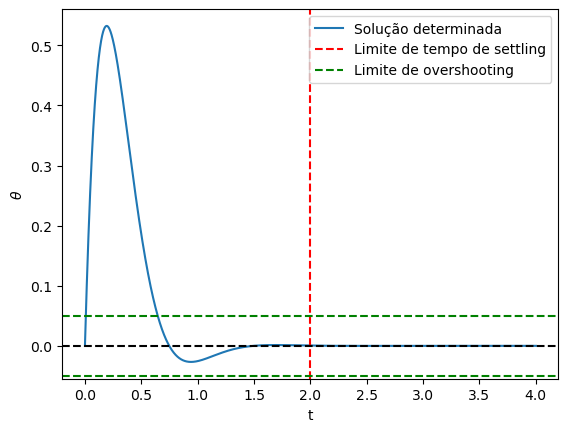

In [13]:
xi = np.sqrt(np.log(20)**2 / (np.pi**2 + np.log(20)**2))
w = 4/(xi*1)

k2 = 2*I*xi*w
k1 = m*g*h+I*w*w
k = np.array([k1,k2]).reshape((1,2))

print("k = ",k)


# representação gráfica
x0 = np.array([0,0.1/I])
times = np.linspace(0, 4, 10000, endpoint=True)
dt = abs(times[1]-times[0])
xt = np.zeros((len(times), 2))
xt[0] = x0
for i in range(len(times)-1):
    xt[i+1] = xt[i] + dt*(A - B @ k) @ xt[i]

plt.plot(times, xt[:,0], label='Solução determinada')
plt.axvline(2, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axhline(-5e-2, linestyle='--', color='green', label='Limite de overshooting')
plt.axhline(5e-2, linestyle='--', color='green')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

Calculamos $\omega$ usando um settling time a 2% igual a 1s, de modo a garantir que seguimos os objetivos. Se colocassemos um settling time de 2s, o sistema demoraria demasiado a estabilizar.

### Ex.5

- Temos:
$$I\ddot{\theta}=mgh\sin\theta+ \frac{mhv^{2}}{r}\cos\theta + \tau$$
### Ponto de Equilíbrio
- Fazemos:
$$\begin{align*}
0&= mgh\sin\theta+ \frac{mhv^{2}}{r}\cos\theta\\
g\sin\theta&= \frac{-v^{2}}{r}\cos\theta\\
\tan\theta&= \frac{-v^{2}}{gr}\\
\theta_{0}&= \tan^{-1}\left(\frac{-v^{2}}{gr}\right)
\end{align*}$$
- O controlador da 4. não funciona porque agora o sistema não estabiliza em 0.

### Controlador novo
- Podemos expandir em taylor em torno de $\theta_{0}$:
$$\begin{align*}
\sin\theta&= \sin\theta_{0} + \cos\theta_{0}(\theta-\theta_{0})\\
\cos\theta&= \cos\theta_{0}-\sin\theta_{0}(\theta-\theta_{0})
\end{align*}$$
logo:
$$\begin{align*}
I\ddot{\theta}&= mgh\sin\theta_{0} + mgh\cos\theta_{0}(\theta-\theta_{0}) + \frac{mv^{2}h}{r}\cos\theta_{0}- \frac{mv^{2}h}{r}\sin\theta_{0}(\theta-\theta_{0}) + \tau\\
&= \theta \left(mgh\cos\theta_{0} - \frac{mv^{2}h}{r}\sin\theta_{0} \right) + \left[mgh(\sin\theta_{0} - \theta_{0}\cos \theta_{0}) + \frac{mv^{2}h}{r}(\cos\theta_{0} + \theta_{0}\sin\theta_{0}) \right] + \tau\\
&= \theta \left(mgh\cos\theta_{0} - \frac{mv^{2}h}{r}\sin\theta_{0} \right) + \left[-mgh\theta_{0}\cos \theta_{0} + \frac{mv^{2}h}{r}\theta_{0}\sin\theta_{0} \right] + \tau\\
\ddot{\theta}&= \frac{\alpha}{I}\theta + \frac{\tau+\beta}{I}\\
\end{align*}$$
podemos definir a entrada de outra forma:
$$\ddot{\theta}= \frac{\alpha}{I}\theta+\tilde{u}~~~~;~~~~ \tilde{u}=\frac{u+\beta}{I}$$
logo:
$$\dot{x} = \begin{pmatrix}0 & 1 \\ \frac{\alpha}{I} & 0\end{pmatrix}x + \begin{pmatrix}0 \\ 1\end{pmatrix}\tilde{u} \quad \quad;\quad \quad y=\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}x$$

### Condições
- Temos:
$$M=\exp\left(-\frac{\pi\xi}{\sqrt{1-\xi^{2}}}\right)~~~~;~~~~ t_{s(2\%)}=\frac{4}{\xi\omega_{n}}~~,~~ t_{s(5\%)}=\frac{3}{\xi\omega_{n}}$$
o que nos permite calcular
$$\xi=\sqrt{\frac{\ln (\frac{1}{0.05})^{2}}{\pi^{2}+\ln (\frac{1}{0.05})^{2}}}\quad;\quad \omega_{n}=\frac{2}{\xi}$$
- Teremos então o caso de feedback em que:
$$u=-Kx~~\to~~ \tilde{u}=\frac{-Kx+\beta}{I}$$

### Polinómio caraterísitco
- Para estas novas matrizes $A,B$ temos:
$$A-BK=\begin{pmatrix}0 & 1 \\ \alpha/I  & 0\end{pmatrix} - \begin{pmatrix}0 \\ 1/I\end{pmatrix}\begin{pmatrix}k_{1} & k_{2}\end{pmatrix}=\begin{pmatrix}0 & 1 \\ \frac{\alpha-k_{1}}{I} & \frac{-k_{2}}{I}\end{pmatrix}$$
$$\begin{align*}
sI-(A-BK) &= \begin{pmatrix}s & -1\\
\frac{k_{1}-\alpha}{I} & s + \frac{k_{2}}{I}\end{pmatrix}
\end{align*}$$
logo
$$\det [sI-A+BK] = s^{2}+ \frac{k_{2}}{I}s + \frac{k_{1}-\alpha}{I}$$
e como sabemos isto será equivalente a $s^{2} + 2\xi \omega_{n} + \omega_{n}^{2}$. Logo:
$$\frac{k_{2}}{I}= 2\xi\omega_{n}~~\to~~ k_{2}=2I\xi\omega_{n}$$
$$\frac{k_{1}-\alpha}{I}=\omega_{n}^{2}~~\to~~ k_{1}=\alpha+I\omega_{n}^{2}$$

theta0 =  -0.11418010544246351
alpha  =  1.1849155412939778
beta   =  -0.13178140887673565
xi  =  0.7613233160800583
w_n =  8.758093155763548
k =  [[2.33547848 0.20003222]]


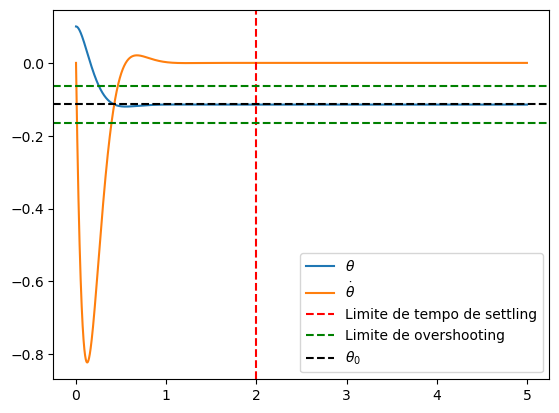

In [14]:
r = 2
v = 1.5

theta0 = np.arctan2(-v*v, g*r)
alpha = m*g*h * np.cos(theta0) - m*v*v*h/r * np.sin(theta0)
beta = m*g*h * theta0*np.cos(theta0) + m*v*v*h/r * theta0*np.sin(theta0)
print("theta0 = ", theta0)
print("alpha  = ", alpha)
print("beta   = ", beta)

A2 = np.array([[0, 1],[alpha/I, 0]])
B2 = np.array([[0],[1]])
C2 = np.eye(2)

xi = np.sqrt(np.log(40)**2 / (np.pi**2 + np.log(40)**2))
w = 1/abs(theta0) 
print("xi  = ", xi)
print("w_n = ", w)

k2 = 2*I*xi*w
k1 = alpha+I*w*w
k = np.array([k1,k2]).reshape((1,2))
print(f"k = ", k)

# representação gráfica
x0 = np.array([0.1,0])
times = np.linspace(0, 5, 10000, endpoint=True)
dt = abs(times[1]-times[0])
xt = np.zeros((len(times), 2))
ut = np.zeros(len(times)) # u é escalar - é torque
xt[0] = x0
ut[0] = ((-k @ xt[0])[0] + beta)/I
for i in range(len(times)-1):
    xt[i+1] = xt[i] + dt*(A2 @ xt[i] + B2.reshape((2,)) * ut[i])
    ut[i+1] = ((-k @ xt[i+1])[0] + beta)/I

plt.plot(times, xt[:,0], label=r'$\theta$')
plt.plot(times, xt[:,1], label=r'$\dot\theta$')
plt.axvline(2, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axhline(theta0-5e-2, linestyle='--', color='green', label='Limite de overshooting')
plt.axhline(theta0+5e-2, linestyle='--', color='green')
plt.axhline(theta0, linestyle='--', color='black', label=r'$\theta_0$')
plt.legend()
plt.show()

k(0.5) =  [[2.33547848 0.10001611]]
k(1) =  [[2.33547848 0.20003222]]
k(3) =  [[2.33547848 0.60009665]]


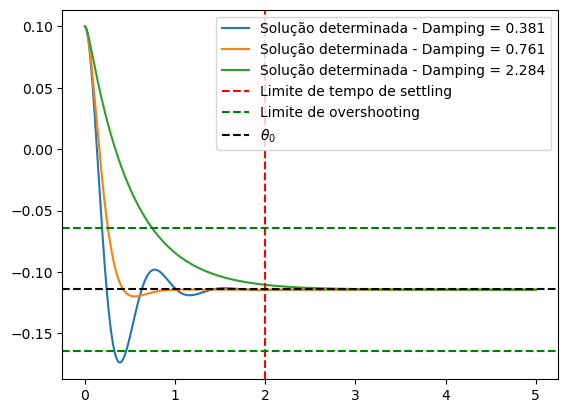

In [15]:
for i in [0.5,1,3]:
    xi = np.sqrt(np.log(40)**2 / (np.pi**2 + np.log(40)**2))*i
    w = 1/abs(theta0) 
    # print("xi  = ", xi)
    # print("w_n = ", w)

    k2 = 2*I*xi*w
    k1 = alpha+I*w*w
    k = np.array([k1,k2]).reshape((1,2))
    print(f"k({i}) = ", k)

    # representação gráfica
    x0 = np.array([0.1,0])
    times = np.linspace(0, 5, 10000, endpoint=True)
    dt = abs(times[1]-times[0])
    xt = np.zeros((len(times), 2))
    ut = np.zeros(len(times)) # u é escalar - é torque
    xt[0] = x0
    ut[0] = ((-k @ xt[0])[0] + beta)/I
    for i in range(len(times)-1):
        xt[i+1] = xt[i] + dt*(A2 @ xt[i] + B2.reshape((2,)) * ut[i])
        ut[i+1] = ((-k @ xt[i+1])[0] + beta)/I

    plt.plot(times, xt[:,0], label=f'Solução determinada - Damping = {xi:.3f}')
plt.axvline(2, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axhline(theta0-5e-2, linestyle='--', color='green', label='Limite de overshooting')
plt.axhline(theta0+5e-2, linestyle='--', color='green')
plt.axhline(theta0, linestyle='--', color='black', label=r'$\theta_0$')
plt.legend()
plt.show()

Variando o valor do damping, podemos observar que o sistema oscila mais ou menos rapidamente. Sendo que quanto maior o valor do damping, menos oscilações terá o sistema. Abaixo de 0.2 o sistema demorará demasiado tempo a estabilizar e apartir de 0.7 estababiliza dentro do valor limite, para damping = 2.2, estamos no limite aceitável de estabilização. Concluindo, o damping ideal será entre 0.7 e 2.2.

## Design of a State Estimator

### Ex.6

**Output theta**
- Consideremos que podemos medir $\theta$. Neste caso teremos $y=\theta$ invés de $y=\begin{pmatrix}\theta &  \dot{\theta}\end{pmatrix}^{T}$
- Assim, como $$\begin{align*}
\dot{x}&= (A-BK)x\\
y&= Cx
\end{align*}$$
temos a segunda equação
$$\theta= C \begin{pmatrix}\theta \\ \dot{\theta}\end{pmatrix}$$
temos que ter:
$$C=\begin{pmatrix}1 & 0\end{pmatrix}$$
- Assim, a matriz de observabilidade associada a este output é:
$$O_{\theta}=\begin{pmatrix}C \\ C(A-BK)\end{pmatrix}=\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}$$
que tem $\text{rank}(O_{\theta})=2$ logo o sistema é completamente observável a partir de $\theta$

**Output derivada de theta**
- Consideremos que podemos medir $\dot{\theta}$. Neste caso teremos $y=\dot{\theta}$ invés de $y=\begin{pmatrix}\theta &  \dot{\theta}\end{pmatrix}^{T}$
- Assim, como 
$$\begin{align*}
\dot{x}&= (A-BK)x\\
y&= Cx
\end{align*}$$
temos a segunda equação
$$\dot{\theta}= C \begin{pmatrix}\theta \\ \dot{\theta}\end{pmatrix}$$
temos que ter:
$$C=\begin{pmatrix}0 & 1\end{pmatrix}$$
- Assim, a matriz de observabilidade associada a este output é:
$$O_{\dot{\theta}}=\begin{pmatrix}C \\ C(A-BK)\end{pmatrix}=\begin{pmatrix}0 & 1 \\ -76.65 & -0.60\end{pmatrix}$$
que tem $\text{rank}(O_{\dot{\theta}})=2$ logo o sistema é completamente observável a partir de $\dot{\theta}$


In [16]:
print("A-BK = ", A-B@k)
print()

C_theta = np.array([1, 0])
O1 = np.array([[C_theta],[C_theta @ (A2-B2@k)]])
print("O1 = ", O1)

C_dtheta = np.array([0, 1])
O2 = np.array([[C_dtheta],[C_dtheta @ (A2-B2@k)]])
print("O1 = ", O2)

rank = np.linalg.matrix_rank(O1)
print("rank(O1) = ", rank)
rank = np.linalg.matrix_rank(O2)
print("rank(O2) = ", rank)

A-BK =  [[  0.           1.        ]
 [-77.21856514 -40.00644314]]

O1 =  [[[1. 0.]]

 [[0. 1.]]]
O1 =  [[[ 0.          1.        ]]

 [[76.65889094 -0.60009665]]]
rank(O1) =  [1 1]
rank(O2) =  [1 1]


### Ex.7

- Temos o sistema
$$\begin{cases}
\dot{x}=Ax+B\tilde{u} \\
\dot{\tilde{x}}=(A-K_{e}C)\tilde{x} + B \tilde{u} + K_{e}y \\
\tilde{u}=\frac{-K \tilde{x}+\beta}{I}
\end{cases}$$
- Logo
$$\begin{align*}
\dot{e}&= \dot{x} - \dot{\tilde{x}}\\
&= Ax+B\tilde{u} - (A-K_{e}C)\tilde{x} -B \tilde{u} - K_{e}y \\
&= Ae - K_{e}(y- C \tilde{x})\\
&= Ae - K_{e}(Cx-C \tilde{x})\\
&= (A-K_{e}C)e
\end{align*}$$
- Temos que o inclinómetro mede $\theta$ logo teremos $C=\begin{pmatrix}1 & 0\end{pmatrix}$ e temos
$$A - K_{e}C = \begin{pmatrix}0 & 1 \\ 79 & 0\end{pmatrix} - \begin{pmatrix}k_{e1} \\ k_{e2}\end{pmatrix}\begin{pmatrix}1 & 0\end{pmatrix}=\begin{pmatrix}-k_{e1} & 1 \\ 79-k_{e2} & 0\end{pmatrix}$$
logo
$$\det(sI - A + K_{e}C)=\det \begin{pmatrix}s + k_{e1} & -1 \\ k_{e2}-79 & s\end{pmatrix}=s^{2} + k_{e1}s + k_{e2}-79$$
-  Para as condições que queremos, temos $\lambda_{max}\le-1.15$ logo decidimos colocar os polos em $\lambda=-2$. Assim
$$\begin{align*}
s^{2} + k_{e1}s + k_{e2}-79 &= (s-\lambda)^{2}\\
&= s^{2}-2\lambda+\lambda^{2}
\end{align*}$$
logo
$$\begin{align*}
k_{e1}&= -2\lambda\\
k_{e2}&= 79 + \lambda^{2}
\end{align*}$$

In [17]:
print(np.log(0.025)/1)

-3.6888794541139363


Ke =  [[ 4.        ]
 [82.99436942]]
xi  =  0.7613233160800583
w_n =  8.758093155763548


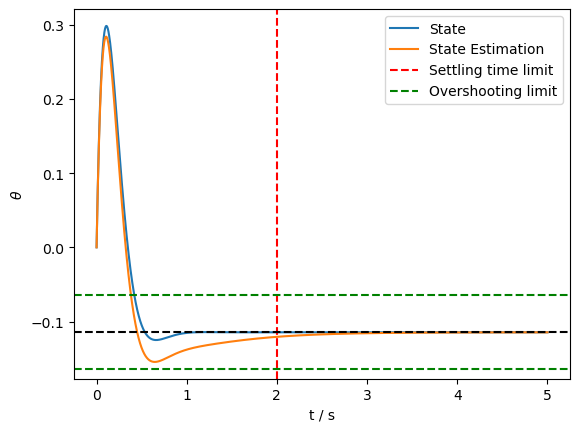

C:\Users\Lucas Monteiro\AppData\Local\Temp\ipykernel_2464\1892320845.py:47: RuntimeWarning: invalid value encountered in divide
  plt.plot(times, abs((xt[:,0]-x_til[:,0])/abs(xt[:,0]))*100)


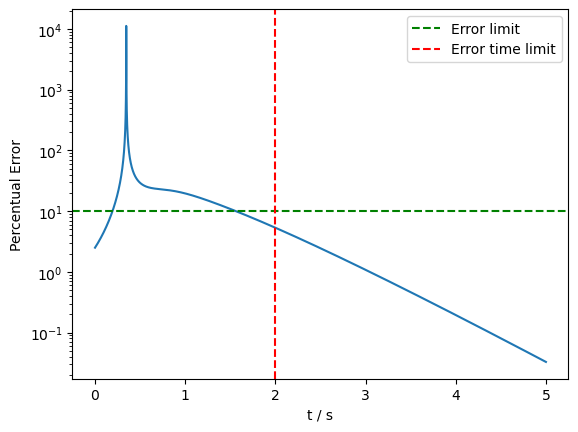

Ke =  [[ 8.        ]
 [94.99436942]]
xi  =  0.7613233160800583
w_n =  8.758093155763548


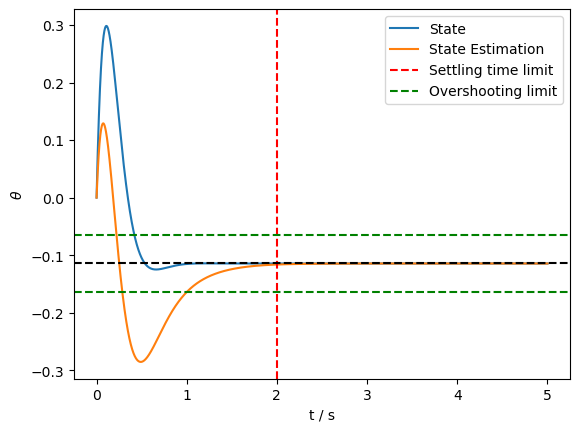

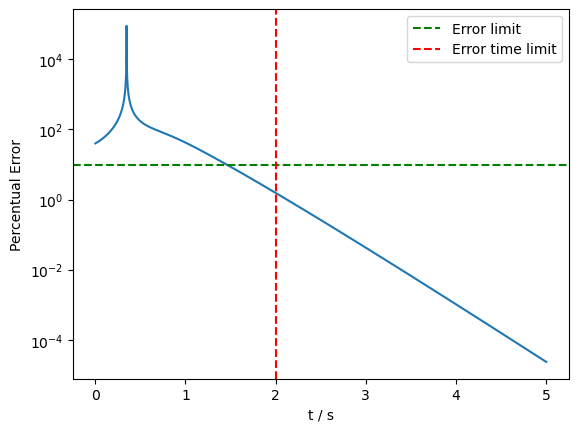

Ke =  [[ 12.        ]
 [114.99436942]]
xi  =  0.7613233160800583
w_n =  8.758093155763548


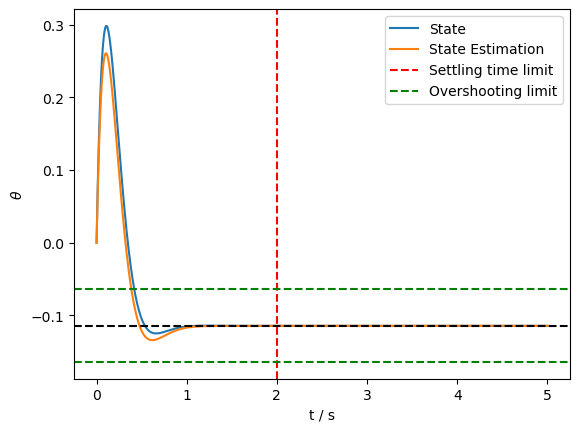

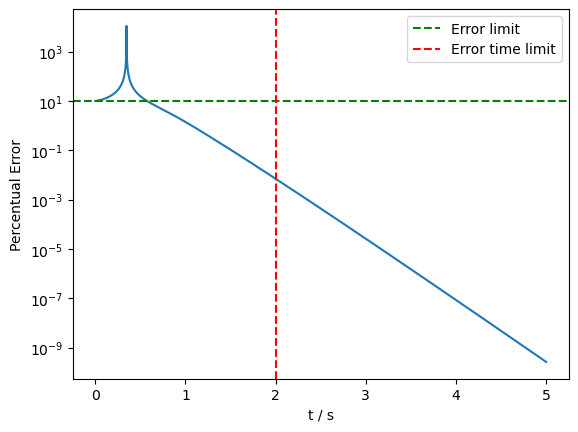

In [28]:
lambdaa=[-2,-4,-6]
mult=[0.975, 0.6, 0.9]

for i in range(3):
    lamb = lambdaa[i]
    ke1 = -2*lamb
    ke2 = A2[1,0] + lamb**2
    ke = np.array([ke1,ke2]).reshape((2,1))

    print("Ke = ",ke)

    xi = np.sqrt(np.log(40)**2 / (np.pi**2 + np.log(40)**2))
    w = 1/abs(theta0) # porquê que funciona?????
    print("xi  = ", xi)
    print("w_n = ", w)

    k2 = 2*I*xi*w
    k1 = alpha+I*w*w
    k = np.array([k1,k2]).reshape((1,2))

    C2theta = np.array(([1, 0])).reshape((1,2))

    # representação gráfica
    x0 = np.array([0,0.1/I])
    times = np.linspace(0, 5, 10000, endpoint=True)
    dt = abs(times[1]-times[0])
    xt = np.zeros((len(times), 2))
    x_til = np.zeros_like(xt)
    ut = np.zeros(len(times)) # u é escalar - é torque
    x_til[0]= x0*mult[i]
    xt[0] = x0
    ut[0] = ((-k @ xt[0])[0] + beta)/I
    for i in range(len(times)-1):
        xt[i+1] = xt[i] + dt*(A2 @ xt[i] + B2.reshape((2,)) * ut[i])
        x_til[i+1] = x_til[i] + dt * (A2 @ x_til[i] + B2.reshape((2,)) * ut[i] + ke @ (C2theta @ xt[i] - C2theta @ x_til[i]))
        ut[i+1] = ((-k @ xt[i+1])[0] + beta)/I
    plt.plot(times, xt[:,0], label=f'State')
    plt.plot(times, x_til[:,0], label=f'State Estimation')
    plt.axvline(2, linestyle='--', color='red', label='Settling time limit')
    plt.axhline(theta0-5e-2, linestyle='--', color='green', label='Overshooting limit')
    plt.axhline(theta0+5e-2, linestyle='--', color='green')
    plt.axhline(theta0, linestyle='--', color='black')
    plt.xlabel('t / s')
    plt.ylabel(r'$\theta$')
    plt.legend()
    plt.show()
    plt.plot(times, abs((xt[:,0]-x_til[:,0])/abs(xt[:,0]))*100)
    plt.axhline(10, linestyle='--', color='green', label='Error limit')
    plt.axvline(2, linestyle='--', color='red', label='Error time limit')
    plt.yscale('log')
    plt.ylabel('Percentual Error')
    plt.xlabel('t / s')
    plt.legend()
    plt.show()

O estado estimado tem overshoot e maior oscilação, ainda que seja capaz de estabilizar ao mesmo ritmo que o estado real.

## Controller and State Estimator

### Ex.8

Ke =  [[ 10.        ]
 [103.99436942]]
xi  =  0.7613233160800583
w_n =  8.758093155763548


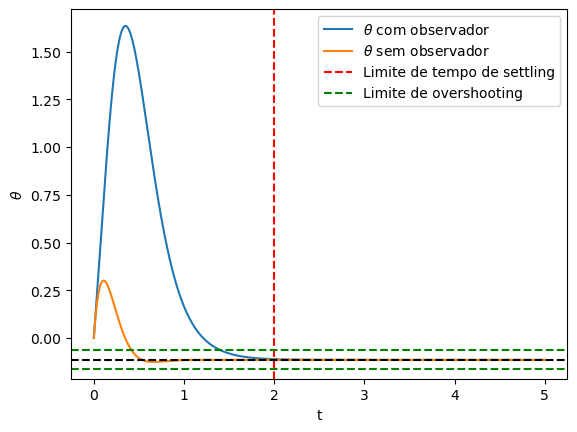

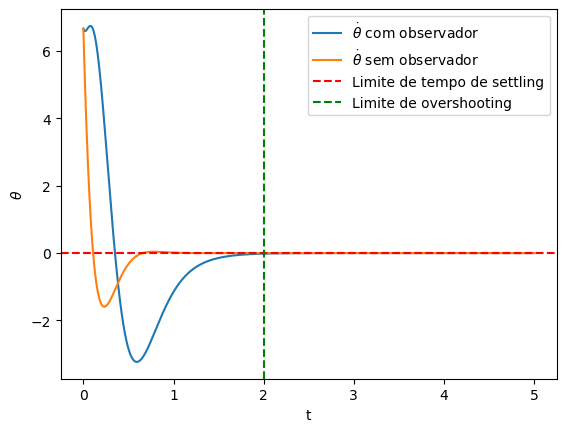

In [34]:
lamb = -5
ke1 = -2*lamb
ke2 = A2[1,0] + lamb**2
ke = np.array([ke1,ke2]).reshape((2,1))

print("Ke = ",ke)

xi = np.sqrt(np.log(40)**2 / (np.pi**2 + np.log(40)**2))
w = 1/abs(theta0) # porquê que funciona?????
print("xi  = ", xi)
print("w_n = ", w)

k2 = 2*I*xi*w
k1 = alpha+I*w*w
k = np.array([k1,k2]).reshape((1,2))

C2theta = np.array(([1, 0])).reshape((1,2))

# representação gráfica
x0 = np.array([0,0.1/I])
times = np.linspace(0, 5, 10000, endpoint=True)
dt = abs(times[1]-times[0])
xt_com_obs = np.zeros((len(times), 2))
x_til = np.zeros_like(xt_com_obs)
xt_sem_obs = np.zeros_like(xt_com_obs)
ut = np.zeros(len(times)) # u é escalar - é torque
xt_com_obs[0] = x0
xt_sem_obs[0] = x0
ut[0] = ((-k @ x_til[0])[0] + beta)/I
for i in range(len(times)-1):
    xt_com_obs[i+1] = xt_com_obs[i] + dt*(A2 @ xt_com_obs[i] + B2.reshape((2,)) * ut[i])
    x_til[i+1] = x_til[i] + dt * (A2 @ x_til[i] + B2.reshape((2,)) * ut[i] + ke @ (C2theta @ xt_com_obs[i] - C2theta @ x_til[i]))
    ut[i+1] = ((-k @ x_til[i+1])[0] + beta)/I
for i in range(len(times)-1):
    xt_sem_obs[i+1] = xt_sem_obs[i] + dt*(A2 @ xt_sem_obs[i] + B2.reshape((2,)) * ut[i])
    ut[i+1] = ((-k @ xt_sem_obs[i+1])[0] + beta)/I
plt.plot(times, xt_com_obs[:,0], label=r'$\theta$ com observador')
plt.plot(times, xt_sem_obs[:,0], label=r'$\theta$ sem observador')
plt.axvline(2, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axhline(theta0-5e-2, linestyle='--', color='green', label='Limite de overshooting')
plt.axhline(theta0+5e-2, linestyle='--', color='green')
plt.axhline(theta0, linestyle='--', color='black')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()
plt.plot(times, xt_com_obs[:,1], label=r'$\dot\theta$ com observador')
plt.plot(times, xt_sem_obs[:,1], label=r'$\dot\theta$ sem observador')
plt.axhline(0, linestyle='--', color='red', label='Limite de tempo de settling')
plt.axvline(2, linestyle='--', color='green', label='Limite de overshooting')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

Mais uma vez, o observador provoca overshoot e maior oscilação, mas é capaz de estabilizar dentro dos parâmetros desejados.